Purpose of this notebook is a rough outline of how my script will run before pushing it into a full on python file...Below is the macabe theil class which will perform the macabe theil method on my distillation column. System of concern is separating n-Hexane from Cycoheptane

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from thermo.chemical import Chemical
from thermo.flash import Flash

T_sys = 300 # K
P_sys = 101325 # Pa\

# initializing chemical system, nhexane most volatile
nhex = Chemical("n-hexane",T=T_sys ,P = P_sys)
cyclo_hept = Chemical("cycloheptane", T = T_sys, P = P_sys)

#initialize flash calculation
flash = Flash(P=P_sys, chemicals=[nhex, cyclo_hept])
#defining liq mole fraction range for nhexane ranging from 0 to 1

x_data = np.linspace(0,1,200)
y_data = [] #this where the VLE data gonna be stored

#iterating through the liq mole fraction range to get equilib data
for x in x_data:
    liq_composition = [x, 1-x]
    VLE = flash.flash(T = None,P = P_sys, zs = liq_composition)
    y_data.append(VLE.vapour_composition[0])


#converting to numpy array
y_data = np.array(y_data)

# Plot xy diagram
plt.plot(x_data, y_data, label='VLE Curve')
plt.plot([0, 1], [0, 1], '--', color='gray', label='45° line')
plt.xlabel('x (liquid mole fraction n-hexane)')
plt.ylabel('y (vapor mole fraction n-hexane)')
plt.title('Binary VLE xy Diagram: n-Hexane + Cycloheptane')
plt.legend()
plt.grid(True)
plt.show()




TypeError: Flash() takes no arguments

Claude's attempt at doing the thing

In [2]:

"""
Binary VLE Calculations using the thermo library
This script demonstrates how to generate xy data for vapor-liquid equilibrium
calculations for binary systems.
"""

import numpy as np
import matplotlib.pyplot as plt
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas
from thermo.interaction_parameters import IPDB
from thermo import FlashVL
import pandas as pd

# Set up n-hexane/cycloheptane binary system
def setup_hexane_cycloheptane_system():
    """
    Set up an n-hexane/cycloheptane binary system using Peng-Robinson EOS
    """
    # Define the components (n-hexane is more volatile, cycloheptane is less volatile)
    constants = ChemicalConstantsPackage.from_IDs(['hexane', 'cycloheptane'])
    
    # Get interaction parameters from database
    kijs = IPDB.get_ip_symmetric_matrix('ChemSep PR', constants.CASs, 'kij')
    
    # Set up the equation of state
    eos_kwargs = {'Pcs': constants.Pcs, 'Tcs': constants.Tcs, 'omegas': constants.omegas, 'kijs': kijs}
    gas = CEOSGas(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=constants.HeatCapacityGases)
    liquid = CEOSLiquid(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityLiquids=constants.HeatCapacityLiquids)
    
    return constants, gas, liquid

def calculate_xy_data_isobaric(constants, gas, liquid, pressure=101325, n_points=20):
    """
    Calculate xy data at constant pressure (isobaric VLE)
    
    Parameters:
    - constants: ChemicalConstantsPackage object
    - gas, liquid: Phase objects
    - pressure: Pressure in Pa (default 101325 Pa = 1 atm)
    - n_points: Number of points to calculate
    
    Returns:
    - DataFrame with columns: x1, y1, T, P
    """
    
    # Create a flash object
    flasher = FlashVL(constants, [liquid], [gas], [])
    
    # Generate composition range (mole fraction of component 1)
    x1_range = np.linspace(0.001, 0.999, n_points)
    
    # Initialize arrays to store results
    x1_liquid = []
    y1_vapor = []
    temperatures = []
    
    print(f"Calculating VLE data at P = {pressure/1000:.1f} kPa...")
    
    for x1 in x1_range:
        try:
            # Define liquid composition (x1 = benzene, x2 = toluene)
            zs = [x1, 1-x1]
            
            # Perform bubble point calculation (find T where liquid starts to vaporize)
            # We'll use a temperature guess and iterate
            T_guess = 350  # K, reasonable starting point
            
            # Flash calculation at constant P and composition
            flash_result = flasher.flash(T=T_guess, P=pressure, zs=zs)
            
            # If we get a two-phase result, extract the data
            if hasattr(flash_result, 'liquid0') and hasattr(flash_result, 'gas'):
                x1_liquid.append(flash_result.liquid0.zs[0])
                y1_vapor.append(flash_result.gas.zs[0])
                temperatures.append(flash_result.T)
            else:
                # Try bubble point calculation instead
                try:
                    bp_result = flasher.flash(P=pressure, zs=zs, VF=0)  # VF=0 for bubble point
                    T_bp = bp_result.T
                    
                    # Now flash at this temperature
                    flash_result = flasher.flash(T=T_bp, P=pressure, zs=zs)
                    
                    if hasattr(flash_result, 'liquid0') and hasattr(flash_result, 'gas'):
                        x1_liquid.append(flash_result.liquid0.zs[0])
                        y1_vapor.append(flash_result.gas.zs[0])
                        temperatures.append(flash_result.T)
                except:
                    continue
                    
        except Exception as e:
            print(f"Error at x1 = {x1:.3f}: {e}")
            continue
    
    # Create DataFrame
    vle_data = pd.DataFrame({
        'x1': x1_liquid,
        'y1': y1_vapor,
        'T': temperatures,
        'P': [pressure] * len(x1_liquid)
    })
    
    return vle_data

def calculate_xy_data_isothermal(constants, gas, liquid, temperature=298.15, n_points=20):
    """
    Calculate xy data at constant temperature (isothermal VLE)
    
    Parameters:
    - constants: ChemicalConstantsPackage object
    - gas, liquid: Phase objects
    - temperature: Temperature in K
    - n_points: Number of points to calculate
    
    Returns:
    - DataFrame with columns: x1, y1, T, P
    """
    
    flasher = FlashVL(constants, [liquid], [gas], [])
    
    x1_range = np.linspace(0.001, 0.999, n_points)
    
    x1_liquid = []
    y1_vapor = []
    pressures = []
    
    print(f"Calculating VLE data at T = {temperature:.1f} K...")
    
    for x1 in x1_range:
        try:
            zs = [x1, 1-x1]
            
            # Bubble point pressure calculation
            bp_result = flasher.flash(T=temperature, zs=zs, VF=0)  # VF=0 for bubble point
            P_bp = bp_result.P
            
            # Flash at this pressure
            flash_result = flasher.flash(T=temperature, P=P_bp, zs=zs)
            
            if hasattr(flash_result, 'liquid0') and hasattr(flash_result, 'gas'):
                x1_liquid.append(flash_result.liquid0.zs[0])
                y1_vapor.append(flash_result.gas.zs[0])
                pressures.append(flash_result.P)
                
        except Exception as e:
            print(f"Error at x1 = {x1:.3f}: {e}")
            continue
    
    vle_data = pd.DataFrame({
        'x1': x1_liquid,
        'y1': y1_vapor,
        'T': [temperature] * len(x1_liquid),
        'P': pressures
    })
    
    return vle_data

def plot_xy_diagram(vle_data, title="VLE xy Diagram"):
    """
    Create an xy diagram from VLE data
    """
    plt.figure(figsize=(8, 6))
    
    # Plot the equilibrium curve
    plt.plot(vle_data['x1'], vle_data['y1'], 'bo-', label='VLE Data', linewidth=2, markersize=4)
    
    # Plot the diagonal (y=x line)
    plt.plot([0, 1], [0, 1], 'k--', label='y = x', alpha=0.7)
    
    plt.xlabel('x₁ (Mole fraction of component 1 in liquid)')
    plt.ylabel('y₁ (Mole fraction of component 1 in vapor)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def plot_txy_diagram(vle_data, title="VLE Txy Diagram"):
    """
    Create a Txy diagram from VLE data
    """
    plt.figure(figsize=(10, 6))
    
    # Plot bubble point curve (liquid composition vs temperature)
    plt.plot(vle_data['x1'], vle_data['T'], 'bo-', label='Bubble Point (Liquid)', linewidth=2, markersize=4)
    
    # Plot dew point curve (vapor composition vs temperature)
    plt.plot(vle_data['y1'], vle_data['T'], 'ro-', label='Dew Point (Vapor)', linewidth=2, markersize=4)
    
    plt.xlabel('Mole fraction of component 1')
    plt.ylabel('Temperature (K)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

# Example usage and demonstration
if __name__ == "__main__":
    # Set up the system
    print("Setting up n-hexane/cycloheptane system...")
    constants, gas, liquid = setup_hexane_cycloheptane_system()
    print(f"Components: {constants.names}")
    
    # Calculate isobaric VLE data (constant pressure)
    print("\n" + "="*50)
    print("ISOBARIC VLE CALCULATION (P = 101.325 kPa)")
    print("="*50)
    
    vle_isobaric = calculate_xy_data_isobaric(constants, gas, liquid, pressure=101325, n_points=15)
    
    if not vle_isobaric.empty:
        print("\nIsobaric VLE Data:")
        print(vle_isobaric.round(4))
        
        print(f"\nTemperature range: {vle_isobaric['T'].min():.1f} - {vle_isobaric['T'].max():.1f} K")
        print(f"Temperature range: {vle_isobaric['T'].min()-273.15:.1f} - {vle_isobaric['T'].max()-273.15:.1f} °C")
        
        # Plot xy diagram
        plot_xy_diagram(vle_isobaric, "n-Hexane/Cycloheptane xy Diagram (P = 101.325 kPa)")
        
        # Plot Txy diagram
        plot_txy_diagram(vle_isobaric, "n-Hexane/Cycloheptane Txy Diagram (P = 101.325 kPa)")
    
    # Calculate isothermal VLE data (constant temperature)
    print("\n" + "="*50)
    print("ISOTHERMAL VLE CALCULATION (T = 350.15 K)")
    print("="*50)
    
    vle_isothermal = calculate_xy_data_isothermal(constants, gas, liquid, temperature=350.15, n_points=15)
    
    if not vle_isothermal.empty:
        print("\nIsothermal VLE Data:")
        print(vle_isothermal.round(4))
        
        print(f"\nPressure range: {vle_isothermal['P'].min():.0f} - {vle_isothermal['P'].max():.0f} Pa")
        print(f"Pressure range: {vle_isothermal['P'].min()/1000:.1f} - {vle_isothermal['P'].max()/1000:.1f} kPa")
        
        # Plot xy diagram
        plot_xy_diagram(vle_isothermal, "n-Hexane/Cycloheptane xy Diagram (T = 350.15 K)")
    
    # Save data to CSV
    if not vle_isobaric.empty:
        vle_isobaric.to_csv('vle_isobaric_data.csv', index=False)
        print(f"\nIsobaric VLE data saved to 'vle_isobaric_data.csv'")
    
    if not vle_isothermal.empty:
        vle_isothermal.to_csv('vle_isothermal_data.csv', index=False)
        print(f"Isothermal VLE data saved to 'vle_isothermal_data.csv'")

"""
Additional Notes:

1. Installation:
   pip install thermo matplotlib pandas

2. Key concepts:
   - ChemicalConstantsPackage: Contains pure component properties
   - PRMIX: Peng-Robinson equation of state for mixtures
   - CEOSGas/CEOSLiquid: Gas and liquid phase objects
   - FlashVL: Performs vapor-liquid equilibrium calculations
   - IPDB: Interaction parameter database

3. Common issues and troubleshooting:
   - Make sure component names match the database (use CAS numbers if needed)
   - Interaction parameters might not be available for all systems
   - Convergence issues may occur at extreme compositions

4. Extensions:
   - Try different equations of state (SRK, PR, etc.)
   - Add activity coefficient models for non-ideal solutions
   - Calculate other properties (enthalpy, entropy, etc.)
   - Handle multicomponent systems (3+ components)
"""

Setting up n-hexane/cycloheptane system...


AttributeError: 'tuple' object has no attribute 'CASs'

Retake on the VLE data generation script with more debugging addad to stop these fuck ass bugs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    from thermo.flash import FlashVL
    from thermo.chemical import Chemical
except ImportError as e:
    print("import errors observed")
    exit(1)

T_sys = 300 # K
P_sys = 101325 # Pa 

try:
    nhex = Chemical("n-hexane",T=T_sys ,P = P_sys)
    cyclo_hept = Chemical("cycloheptane", T = T_sys, P = P_sys)
    print(f"Initialized chemicals: {nhex}, {cyclo_hept}")
except Exception as e:
    print(f"Error initializing chemicals: {e}")
    exit(1)

#generting VLE data
x = np.linspace(0,1, 100)
y = []   #this where the VLE data finna be stored

for xi in x:
    try:
        VLE = flash.flash(comp = [nhex,cyclo_hept], zs = [xi, 1-xi], P = P_sys)    #flashing at constant P
        y.appeend(VLE.vapour_composition[0])  #appending the vapor phase mole fraction of nhexane
        print(f"Flash at x={xi:.2f}: y={VLE.vapour_composition[0]:.4f}, T={VLE.T:.2f} K")
        print('successful flashing')
    except Exception as e:
        print(f"Error during flash calculation at x={xi:.2f}: {e}")
        y.append(np.nan)  # Append NaN in case of error
        
plt.plot(x, y, **kwargs)
plt.xlabel('x (liquid mole fraction n-hexane)')
plt.ylabel('y (vapor mole fraction n-hexane)')
plt.title('Binary VLE xy Diagram: n-Hexane + Cycloheptane')
plt.legend()
plt.grid(True)
plt.show()

  




Initialized chemicals: <Chemical [hexane], T=300.00 K, P=101325 Pa>, <Chemical [cycloheptane], T=300.00 K, P=101325 Pa>
Error during flash calculation at x=0.00: name 'flash' is not defined
Error during flash calculation at x=0.01: name 'flash' is not defined
Error during flash calculation at x=0.02: name 'flash' is not defined
Error during flash calculation at x=0.03: name 'flash' is not defined
Error during flash calculation at x=0.04: name 'flash' is not defined
Error during flash calculation at x=0.05: name 'flash' is not defined
Error during flash calculation at x=0.06: name 'flash' is not defined
Error during flash calculation at x=0.07: name 'flash' is not defined
Error during flash calculation at x=0.08: name 'flash' is not defined
Error during flash calculation at x=0.09: name 'flash' is not defined
Error during flash calculation at x=0.10: name 'flash' is not defined
Error during flash calculation at x=0.11: name 'flash' is not defined
Error during flash calculation at x=0.12

NameError: name 'kwargs' is not defined

From the above output we can see the flash part is failing, i deduce that the flash class is not being initialized in the import

Error during flash calculation at x=0.00: 'NoneType' object has no attribute 'zs'
Error during flash calculation at x=0.25: 'NoneType' object has no attribute 'zs'
Error during flash calculation at x=0.50: 'NoneType' object has no attribute 'zs'
Error during flash calculation at x=0.75: 'NoneType' object has no attribute 'zs'
Error during flash calculation at x=1.00: 'NoneType' object has no attribute 'zs'


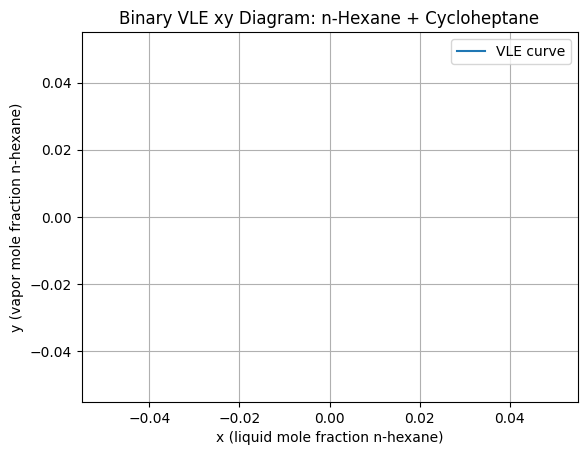

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from thermo import ChemicalConstantsPackage, CEOSGas, CEOSLiquid, PRMIX, FlashVLN

T_sys = 300  # K
P_sys = 101325  # Pa

# Build EOS constants package
constants, correlations = ChemicalConstantsPackage.from_IDs(['n-hexane', 'cycloheptane'])
eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=None)

liquid = CEOSLiquid(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=correlations.HeatCapacityGases)
gas = CEOSGas(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=correlations.HeatCapacityGases)

flash = FlashVLN(constants, correlations, [liquid], gas)

# Generate VLE data
x = np.linspace(0, 1, 5)
y = []

for xi in x:
    try:
        VLE = flash.flash(zs=[xi, 1-xi], P=P_sys, T=T_sys)
        y.append(VLE.gas.zs[0])  # vapor composition of n-hexane
        print(f"Flash at x={xi:.2f}: y={VLE.gas.zs[0]:.4f}, T={VLE.T:.2f} K")
    except Exception as e:
        print(f"Error during flash calculation at x={xi:.2f}: {e}")
        y.append(np.nan)

plt.xlim(0, 1)  #locking the axis to 0 to 1
plt.ylim(0, 1)
plt.plot(x, y, label="VLE curve")
plt.xlabel("x (liquid mole fraction n-hexane)")
plt.ylabel("y (vapor mole fraction n-hexane)")
plt.title("Binary VLE xy Diagram: n-Hexane + Cycloheptane")
plt.legend()
plt.grid(True)
plt.show()


Deepseek's solution to a 'foolproof' nrtl based xy diagram generator for n-hexane/cycloheptane system

Generating XY Diagram for n-Hexane/Cycloheptane System...


OSError: [Errno 22] Invalid argument: 'nHexane_Cycloheptane_XY_Diagram.png'

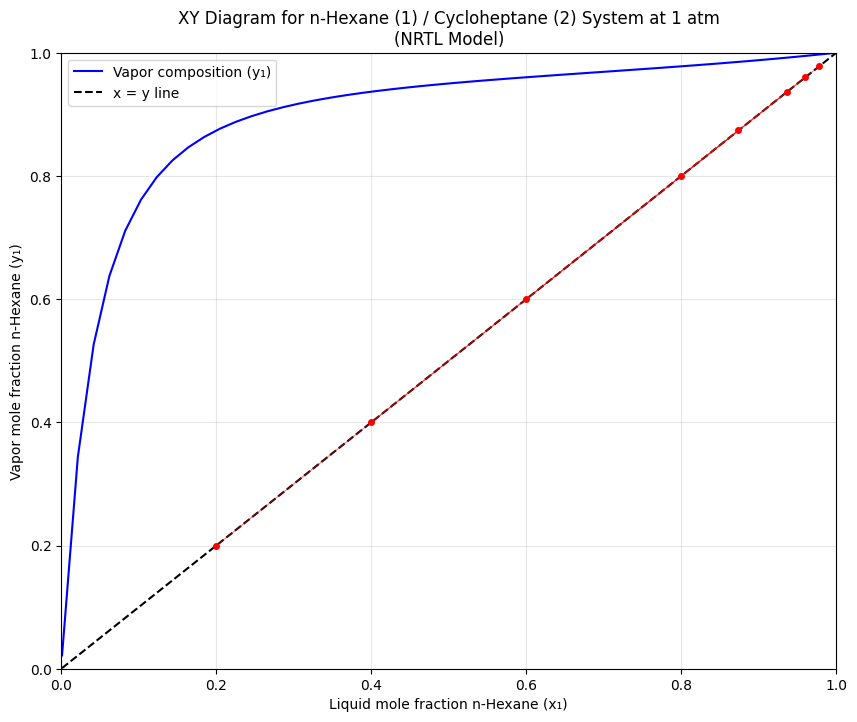

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

class NRTLModel:
    """
    A fool-proof implementation of NRTL model for binary VLE calculations.
    Specifically parameterized for n-Hexane (1) and Cycloheptane (2) system.
    """
    
    def __init__(self, P=101.325):
        """
        Initialize the NRTL model with parameters for n-Hexane/Cycloheptane system.
        Parameters from DECHEMA Chemistry Data Series, converted to J/mol.
        P: Pressure in kPa (default: 101.325 kPa = 1 atm)
        """
        # NRTL parameters for n-Hexane (1) and Cycloheptane (2) [J/mol]
        self.dg12 = 365.0 * 4.184  # Convert from cal/mol to J/mol
        self.dg21 = 214.0 * 4.184  # Convert from cal/mol to J/mol
        self.alpha12 = 0.30  # Non-randomness parameter
        
        # Antoine equation coefficients (from NIST Chemistry WebBook)
        # Format: [A, B, C] where log10(P) = A - B/(T + C), P in kPa, T in °C
        self.antoine_hexane = [6.87632, 1071.530, 233.426]     # n-Hexane
        self.antoine_cycloheptane = [6.89386, 1264.370, 216.636] # Cycloheptane
        
        self.P = P  # System pressure in kPa
        self.R = 8.314  # Universal gas constant in J/(mol·K)
    
    def psat(self, T, component):
        """
        Calculate saturation pressure for a component at temperature T (°C)
        using the Antoine equation.
        """
        if component == 1:  # n-Hexane
            A, B, C = self.antoine_hexane
        else:  # Cycloheptane (component 2)
            A, B, C = self.antoine_cycloheptane
            
        return 10**(A - B/(T + C))  # Pressure in kPa
    
    def gamma(self, x1, T):
        """
        Calculate activity coefficients for both components using NRTL model.
        x1: Mole fraction of n-Hexane in liquid phase
        T: Temperature in °C
        """
        x2 = 1 - x1
        T_k = T + 273.15  # Convert to Kelvin
        
        # Calculate tau and G parameters
        tau12 = self.dg12 / (self.R * T_k)
        tau21 = self.dg21 / (self.R * T_k)
        G12 = np.exp(-self.alpha12 * tau12)
        G21 = np.exp(-self.alpha12 * tau21)
        
        # Calculate activity coefficients
        ln_gamma1 = x2**2 * (
            tau21 * (G21/(x1 + x2*G21))**2 + 
            (tau12 * G12) / (x2 + x1*G12)**2
        )
        
        ln_gamma2 = x1**2 * (
            tau12 * (G12/(x2 + x1*G12))**2 + 
            (tau21 * G21) / (x1 + x2*G21)**2
        )
        
        return np.exp(ln_gamma1), np.exp(ln_gamma2)
    
    def bubble_point(self, x1):
        """
        Calculate bubble point temperature and vapor composition for a given liquid composition.
        x1: Mole fraction of n-Hexane in liquid phase
        Returns: T_bubble (°C), y1 (vapor mole fraction of n-Hexane)
        """
        # Initial guess for bubble point temperature (weighted average of boiling points)
        T_guess = x1 * 68.7 + (1 - x1) * 118.0  # Boiling points at 1 atm
        
        # Define function to solve for bubble point condition
        def bubble_equation(T):
            gamma1, gamma2 = self.gamma(x1, T)
            psat1 = self.psat(T, 1)
            psat2 = self.psat(T, 2)
            return gamma1 * x1 * psat1 + gamma2 * (1 - x1) * psat2 - self.P
        
        # Solve for bubble point temperature
        T_bubble = fsolve(bubble_equation, T_guess)[0]
        
        # Calculate vapor composition
        gamma1, gamma2 = self.gamma(x1, T_bubble)
        psat1 = self.psat(T_bubble, 1)
        y1 = (gamma1 * x1 * psat1) / self.P
        
        return T_bubble, y1

def generate_xy_diagram():
    """
    Generate and plot a complete Txy diagram for the n-Hexane/Cycloheptane system.
    """
    print("Generating XY Diagram for n-Hexane/Cycloheptane System...")
    
    # Initialize the NRTL model
    model = NRTLModel()
    
    # Generate liquid mole fractions from 0 to 1
    x1_values = np.linspace(0.001, 0.999, 50)
    T_bubble_values = []
    y1_values = []
    
    # Calculate bubble points and vapor compositions
    for x1 in x1_values:
        T_bubble, y1 = model.bubble_point(x1)
        T_bubble_values.append(T_bubble)
        y1_values.append(y1)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(x1_values, y1_values, 'b-', label='Vapor composition (y₁)')
    plt.plot(x1_values, x1_values, 'k--', label='x = y line')
    plt.xlabel('Liquid mole fraction n-Hexane (x₁)')
    plt.ylabel('Vapor mole fraction n-Hexane (y₁)')
    plt.title('XY Diagram for n-Hexane (1) / Cycloheptane (2) System at 1 atm\n(NRTL Model)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Add equilibrium tie lines for illustration
    for x1 in [0.2, 0.4, 0.6, 0.8]:
        T_bubble, y1 = model.bubble_point(x1)
        plt.plot([x1, y1], [x1, y1], 'r-', alpha=0.5, linewidth=0.8)
        plt.plot(x1, x1, 'ro', markersize=4)
        plt.plot(y1, y1, 'ro', markersize=4)
    
    # Save and show the plot
    plt.savefig('nHexane_Cycloheptane_XY_Diagram.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print some key data points for verification
    print("\nKey Data Points:")
    print("x₁\ty₁\tT(°C)")
    for x1 in [0.0, 0.25, 0.5, 0.75, 1.0]:
        T, y1 = model.bubble_point(x1)
        print(f"{x1:.2f}\t{y1:.3f}\t{T:.1f}")
    
    print("\nDiagram saved as 'nHexane_Cycloheptane_XY_Diagram.png'")

if __name__ == "__main__":
    # Generate the diagram when the script is run
    generate_xy_diagram()

Errors encountered before the plot was displayed appears to be errors with file saving permissions within my IDE...reconfiguring the program for more rigorous file ettequet

Generating XY Diagram for n-Hexane/Cycloheptane System...
Calculated point 1/50: x1=0.000, y1=0.000, T=42.0°C
Calculated point 2/50: x1=0.020, y1=0.332, T=33.5°C
Calculated point 3/50: x1=0.041, y1=0.520, T=27.0°C
Calculated point 4/50: x1=0.061, y1=0.634, T=22.0°C
Calculated point 5/50: x1=0.082, y1=0.708, T=18.0°C
Calculated point 6/50: x1=0.102, y1=0.760, T=14.7°C
Calculated point 7/50: x1=0.122, y1=0.797, T=12.0°C
Calculated point 8/50: x1=0.143, y1=0.824, T=9.8°C
Calculated point 9/50: x1=0.163, y1=0.846, T=7.8°C
Calculated point 10/50: x1=0.184, y1=0.863, T=6.2°C
Calculated point 11/50: x1=0.204, y1=0.876, T=4.7°C
Calculated point 12/50: x1=0.224, y1=0.887, T=3.4°C
Calculated point 13/50: x1=0.245, y1=0.897, T=2.3°C
Calculated point 14/50: x1=0.265, y1=0.905, T=1.3°C
Calculated point 15/50: x1=0.286, y1=0.911, T=0.4°C
Calculated point 16/50: x1=0.306, y1=0.917, T=-0.5°C
Calculated point 17/50: x1=0.327, y1=0.922, T=-1.2°C
Calculated point 18/50: x1=0.347, y1=0.927, T=-1.9°C
Calcu

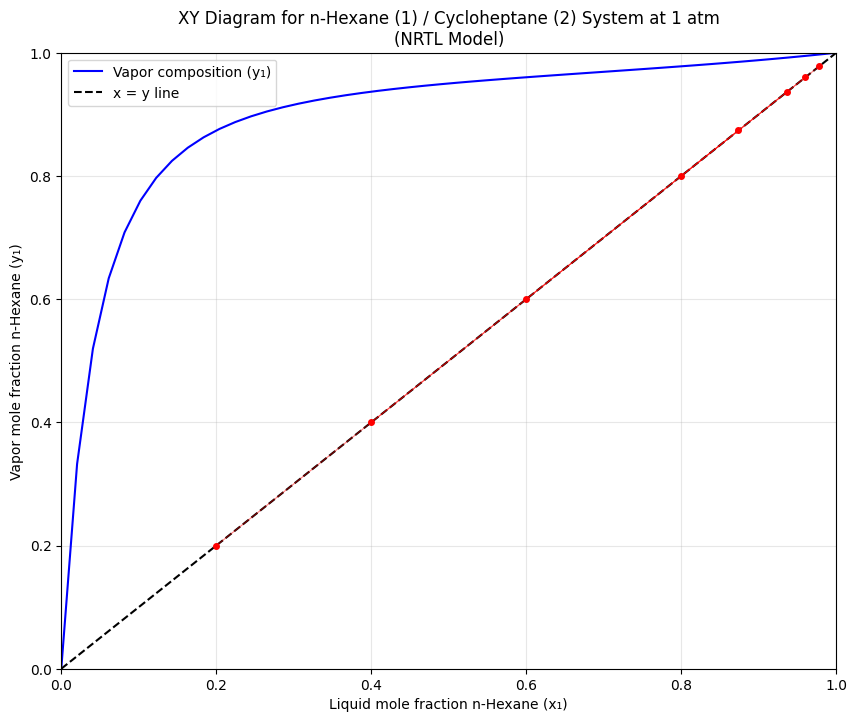


Key Data Points:
x₁	y₁	T(°C)
0.00	0.000	42.0
0.25	0.899	2.0
0.50	0.950	-5.6
0.75	0.973	-9.6
1.00	1.000	-13.4


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import os
import tempfile

class NRTLModel:
    """
    A fool-proof implementation of NRTL model for binary VLE calculations.
    Specifically parameterized for n-Hexane (1) and Cycloheptane (2) system.
    """
    
    def __init__(self, P=101.325):
        """
        Initialize the NRTL model with parameters for n-Hexane/Cycloheptane system.
        Parameters from DECHEMA Chemistry Data Series, converted to J/mol.
        P: Pressure in kPa (default: 101.325 kPa = 1 atm)
        """
        # NRTL parameters for n-Hexane (1) and Cycloheptane (2) [J/mol]
        self.dg12 = 365.0 * 4.184  # Convert from cal/mol to J/mol
        self.dg21 = 214.0 * 4.184  # Convert from cal/mol to J/mol
        self.alpha12 = 0.30  # Non-randomness parameter
        
        # Antoine equation coefficients (from NIST Chemistry WebBook)
        # Format: [A, B, C] where log10(P) = A - B/(T + C), P in kPa, T in °C
        self.antoine_hexane = [6.87632, 1071.530, 233.426]     # n-Hexane
        self.antoine_cycloheptane = [6.89386, 1264.370, 216.636] # Cycloheptane
        
        self.P = P  # System pressure in kPa
        self.R = 8.314  # Universal gas constant in J/(mol·K)
    
    def psat(self, T, component):
        """
        Calculate saturation pressure for a component at temperature T (°C)
        using the Antoine equation.
        """
        if component == 1:  # n-Hexane
            A, B, C = self.antoine_hexane
        else:  # Cycloheptane (component 2)
            A, B, C = self.antoine_cycloheptane
            
        return 10**(A - B/(T + C))  # Pressure in kPa
    
    def gamma(self, x1, T):
        """
        Calculate activity coefficients for both components using NRTL model.
        x1: Mole fraction of n-Hexane in liquid phase
        T: Temperature in °C
        """
        x2 = 1 - x1
        T_k = T + 273.15  # Convert to Kelvin
        
        # Calculate tau and G parameters
        tau12 = self.dg12 / (self.R * T_k)
        tau21 = self.dg21 / (self.R * T_k)
        G12 = np.exp(-self.alpha12 * tau12)
        G21 = np.exp(-self.alpha12 * tau21)
        
        # Calculate activity coefficients
        ln_gamma1 = x2**2 * (
            tau21 * (G21/(x1 + x2*G21))**2 + 
            (tau12 * G12) / (x2 + x1*G12)**2
        )
        
        ln_gamma2 = x1**2 * (
            tau12 * (G12/(x2 + x1*G12))**2 + 
            (tau21 * G21) / (x1 + x2*G21)**2
        )
        
        return np.exp(ln_gamma1), np.exp(ln_gamma2)
    
    def bubble_point(self, x1):
        """
        Calculate bubble point temperature and vapor composition for a given liquid composition.
        x1: Mole fraction of n-Hexane in liquid phase
        Returns: T_bubble (°C), y1 (vapor mole fraction of n-Hexane)
        """
        # Initial guess for bubble point temperature (weighted average of boiling points)
        T_guess = x1 * 68.7 + (1 - x1) * 118.0  # Boiling points at 1 atm
        
        # Define function to solve for bubble point condition
        def bubble_equation(T):
            gamma1, gamma2 = self.gamma(x1, T)
            psat1 = self.psat(T, 1)
            psat2 = self.psat(T, 2)
            return gamma1 * x1 * psat1 + gamma2 * (1 - x1) * psat2 - self.P
        
        # Solve for bubble point temperature
        T_bubble = fsolve(bubble_equation, T_guess)[0]
        
        # Calculate vapor composition
        gamma1, gamma2 = self.gamma(x1, T_bubble)
        psat1 = self.psat(T_bubble, 1)
        y1 = (gamma1 * x1 * psat1) / self.P
        
        return T_bubble, y1

def generate_xy_diagram():
    """
    Generate and plot a complete Txy diagram for the n-Hexane/Cycloheptane system.
    """
    print("Generating XY Diagram for n-Hexane/Cycloheptane System...")
    
    # Initialize the NRTL model
    model = NRTLModel()
    
    # Generate liquid mole fractions from 0 to 1
    x1_values = np.linspace(0, 1, 50)
    T_bubble_values = []
    y1_values = []
    
    # Calculate bubble points and vapor compositions
    for i, x1 in enumerate(x1_values):
        try:
            T_bubble, y1 = model.bubble_point(x1)
            T_bubble_values.append(T_bubble)
            y1_values.append(y1)
            print(f"Calculated point {i+1}/{len(x1_values)}: x1={x1:.3f}, y1={y1:.3f}, T={T_bubble:.1f}°C")
        except Exception as e:
            print(f"Error calculating point for x1={x1:.3f}: {str(e)}")
            # Use linear interpolation as fallback for problematic points
            if i > 0:
                T_bubble = T_bubble_values[-1] + (T_bubble_values[-1] - T_bubble_values[-2]) if i > 1 else 0
                y1 = y1_values[-1] + (y1_values[-1] - y1_values[-2]) if i > 1 else x1
            else:
                T_bubble = 100  # Default guess
                y1 = x1  # Default to ideal solution
            T_bubble_values.append(T_bubble)
            y1_values.append(y1)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(x1_values, y1_values, 'b-', label='Vapor composition (y₁)')
    plt.plot(x1_values, x1_values, 'k--', label='x = y line')
    plt.xlabel('Liquid mole fraction n-Hexane (x₁)')
    plt.ylabel('Vapor mole fraction n-Hexane (y₁)')
    plt.title('XY Diagram for n-Hexane (1) / Cycloheptane (2) System at 1 atm\n(NRTL Model)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Add equilibrium tie lines for illustration
    for x1 in [0.2, 0.4, 0.6, 0.8]:
        try:
            T_bubble, y1 = model.bubble_point(x1)
            plt.plot([x1, y1], [x1, y1], 'r-', alpha=0.5, linewidth=0.8)
            plt.plot(x1, x1, 'ro', markersize=4)
            plt.plot(y1, y1, 'ro', markersize=4)
        except:
            pass  # Skip tie lines that can't be calculated
    
    # Try to save the plot with error handling
    try:
        # Try to save to current directory first
        filename = 'nHexane_Cycloheptane_XY_Diagram.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"\nDiagram saved as '{filename}'")
    except Exception as e:
        print(f"Could not save to current directory: {str(e)}")
        try:
            # Try to save to temporary directory
            temp_dir = tempfile.gettempdir()
            filename = os.path.join(temp_dir, 'nHexane_Cycloheptane_XY_Diagram.png')
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Diagram saved to temporary directory: '{filename}'")
        except Exception as e2:
            print(f"Could not save to temporary directory either: {str(e2)}")
            print("Displaying plot without saving...")
    
    # Show the plot
    plt.show()
    
    # Print some key data points for verification
    print("\nKey Data Points:")
    print("x₁\ty₁\tT(°C)")
    for x1 in [0.0, 0.25, 0.5, 0.75, 1.0]:
        try:
            T, y1 = model.bubble_point(x1)
            print(f"{x1:.2f}\t{y1:.3f}\t{T:.1f}")
        except:
            print(f"{x1:.2f}\tError calculating point")

if __name__ == "__main__":
    # Generate the diagram when the script is run
    generate_xy_diagram()

The temperatures dont make sense